# Stochastic Analysis

## load tables

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [105]:
agents_number_df = pd.read_csv('./agents_results.csv')
agents_number_df = agents_number_df.drop_duplicates(subset='damage')
agents_number_df = agents_number_df.loc[(agents_number_df['num_agents'] <= 500) & (agents_number_df['d'] == 5) & (agents_number_df['sigma'] == 1) & (agents_number_df['f'] == 1.5)]
agents_number_df = agents_number_df.groupby(['planner', 'num_agents'], as_index=False).mean()
agents_number_df.head()

,planner,num_agents,num_robots,f,d,sigma,active_time,planner_time,damage,num_disabled
0,StochasticIterativePlanner,50,5.0,1.5,5.0,1.0,217.850869,0.369549,9859.710593,15.8008
1,StochasticIterativePlanner,100,5.0,1.5,5.0,1.0,227.112760,0.434708,20019.998530,29.0812
2,StochasticIterativePlanner,200,5.0,1.5,5.0,1.0,239.503755,1.133050,41498.873041,49.4458
3,StochasticIterativePlanner,300,5.0,1.5,5.0,1.0,245.728732,2.253198,63730.420573,65.3150
4,StochasticIterativePlanner,400,5.0,1.5,5.0,1.0,251.699382,3.459262,86020.206699,79.0442


In [106]:
f_df = pd.read_csv('./f_results.csv')
f_df = f_df.drop_duplicates(subset='damage')
f_df = f_df.loc[(f_df['num_agents'] == 300)]
f_df = f_df.groupby(['planner', 'f'], as_index=False).mean()
f_df.head()

,planner,f,num_agents,num_robots,d,sigma,active_time,planner_time,damage,num_disabled
0,StochasticIterativePlanner,1.1,300.0,5.0,5.0,1.0,284.145790,0.944603,73015.404814,14.4760
1,StochasticIterativePlanner,1.2,300.0,5.0,5.0,1.0,274.330333,0.920247,70427.460707,29.6010
2,StochasticIterativePlanner,1.3,300.0,5.0,5.0,1.0,261.857269,1.357716,67996.203832,42.3667
3,StochasticIterativePlanner,1.4,300.0,5.0,5.0,1.0,258.327398,1.810812,65828.579418,54.2816
4,StochasticIterativePlanner,1.5,300.0,5.0,5.0,1.0,247.815872,2.210782,63725.955072,65.5200


In [107]:
robots_df = pd.read_csv('./robots_results.csv')
robots_df = robots_df.drop_duplicates(subset=['planner', 'damage'])
robots_df = robots_df.loc[(robots_df['f'] == 1.5)]
robots_df = robots_df.groupby(['planner', 'num_robots'], as_index=False).mean()
robots_df.head()

,planner,num_robots,num_agents,f,d,sigma,active_time,planner_time,damage,num_disabled


## visualizations

In [108]:
planners_colors = {'StochasticIterativePlanner': 'red',
                   'StochasticStaticLackPlanner': 'blue',
                   'StochasticAdditiveLackPlanner': 'orange',
                   'StochasticMonotone15LackPlanner': 'green',
                   'StochasticMonotone20LackPlanner': 'purple',
                   'StochasticMonotone30LackPlanner': 'olive',
                   'StochasticMonotone45LackPlanner': 'cyan'}

In [109]:
from typing import List

def visualize(X: List[str], Y: List[str], data, file_to_save: str, title: str):
    plt.figure(figsize=(14,10))
    plt.suptitle(title, fontsize=18)

    for i in range(len(Y)):
        x, y = X[i], Y[i]

        plt.subplot(2, 2, i+1)
        plt.xlabel(x)
        plt.ylabel(y)
        for j in range(len(data)):
            r = data[j]
            plt.plot(list(r[x]), list(r[y]), c=list(planners_colors.values())[j])

        if i==1:
            plt.legend(planners_colors.keys(), fontsize='14')

    plt.savefig(file_to_save)
    plt.show()

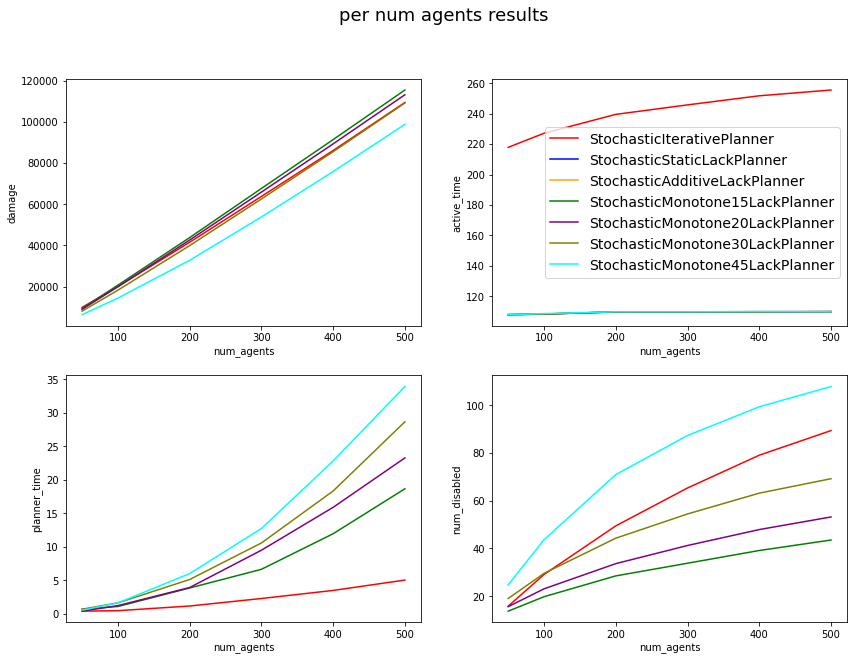

In [110]:
Y = ['damage', 'active_time', 'planner_time', 'num_disabled']
X = ['num_agents' for _ in Y]

agents_results = [agents_number_df.loc[agents_number_df['planner'] == name] for name in planners_colors.keys()]
title = 'per num agents results'
file_to_save = './plots/stochastic_num_agents.png'

visualize(X, Y, agents_results, file_to_save, title)

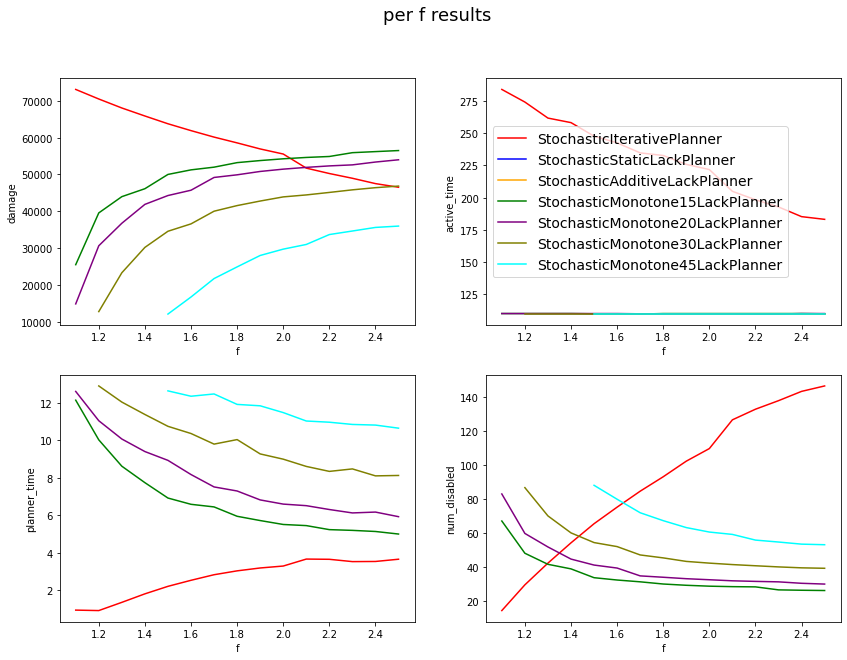

In [111]:
Y = ['damage', 'active_time', 'planner_time', 'num_disabled']
X = ['f' for _ in Y]

f_results = [f_df.loc[f_df['planner'] == name] for name in planners_colors.keys()]
title = 'per f results'
file_to_save = './plots/stochastic_f.png'

visualize(X, Y, f_results, file_to_save, title)

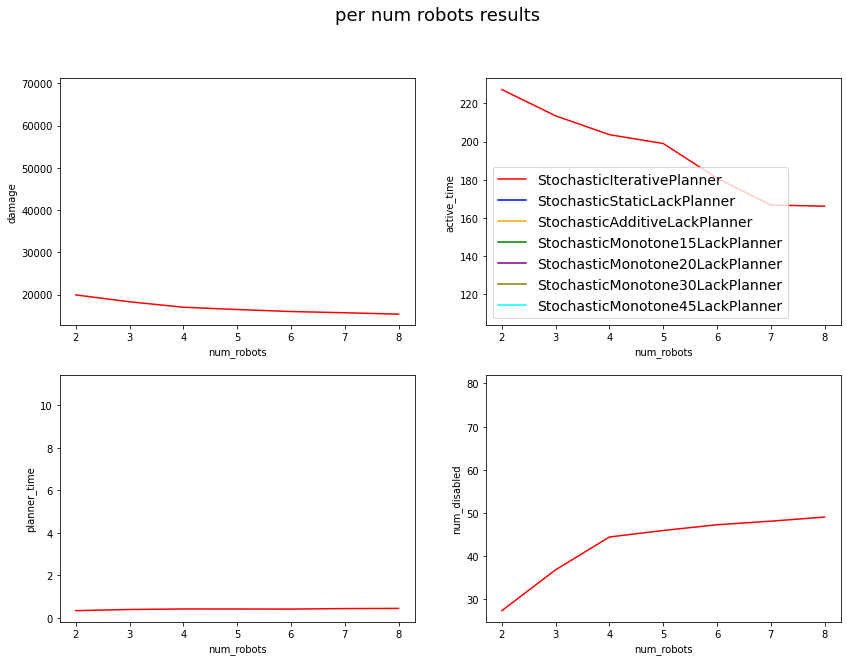

In [24]:
Y = ['damage', 'active_time', 'planner_time', 'num_disabled']
X = ['num_robots' for _ in Y]

robots_results = [robots_df.loc[robots_df['planner'] == name] for name in planners_colors.keys()]
title = 'per num robots results'
file_to_save = './plots/stochastic_num_robots.png'

visualize(X, Y, robots_results, file_to_save, title)

## run experiments

### config file

In [100]:
import json
with open('config.json') as json_file:
    config = json.load(json_file)
config

{'x_size': 100,
 'y_size_init': 100,
 'y_size': 300,
 'x_buffer': 10,
 'y_buffer': 10,
 'num_robots': 5,
 'num_agents': 100,
 'agent_speed': 1,
 'robot_speed': 1.5,
 'disablement_range': 5,
 'sigma': 1}

In [101]:
import math
import time
from random import seed

from planners.stochastic.baseline.stochastic_iterative_planner import StochasticIterativePlanner
from planners.stochastic.partial_blockage.stochastic_additive_lack_planner import StochasticAdditiveLackPlanner
from planners.stochastic.partial_blockage.stochastic_monotone_lack_planner import StochasticMonotoneLackPlanner
from world.agents.stochastic_agent import StochasticAgent
from world.robots.timing_robot import TimingRobot
from world.stochastic_environment import StochasticEnvironment
from planners.planner import Planner
from planners.stochastic.partial_blockage.stochastic_static_lack_planner import StochasticStaticLackPlanner
from utils.functions import *

In [102]:
def run(planner: Planner, file_name: str):
    agents = [StochasticAgent(loc=sample_point(config['x_buffer'], config['x_buffer'] + config['x_size'],
                                               config['y_buffer'], config['y_buffer'] + config['y_size_init'], True),
                              v=config['agent_speed'], sigma=config['sigma']) for _ in range(config['num_agents'])]

    robots = [BasicRobot(sample_point(0, config['x_size'] + 2 * config['x_buffer'], 0, config['y_buffer'], True),
                         config['robot_speed'], config['disablement_range']) for _ in range(config['num_robots'])]

    env = StochasticEnvironment(agents=agents, robots=robots, top_border=config['y_size'] + config['y_buffer'],
                                right_border=config['x_size'] + config['x_buffer'], left_border=config['x_buffer'])

    before = time.time()
    _, active_time, expected_damage, expected_num_disabled = planner.plan(env)
    planning_time = time.time() - before

    write_report(planner=str(planner),
                 num_agents=config['num_agents'],
                 num_robots=config['num_robots'],
                 f=config['robot_speed'] / config['agent_speed'],
                 d=config['disablement_range'],
                 active_or_copmletion_time=active_time,
                 planner_time=planning_time,
                 damage=expected_damage,
                 num_disabled=expected_num_disabled,
                 file_name=file_name,
                 is_active_time=True,
                 sigma=config['sigma'])

In [103]:
planners = [StochasticMonotoneLackPlanner(), StochasticStaticLackPlanner(), StochasticAdditiveLackPlanner()]

for planner in planners:
    for alpha in [math.pi / 4]:
        planner.alpha = alpha
        for v in tqdm([100, 200, 300, 400, 500]):
            print(f'*** *** v={v} *** ***')
            for s in range(10):
                seed(s)

                config['num_agents'] = v
                print(f'running {str(planner)} with seed {s}..')
                run(planner, 'agents_results.csv')

  0%|          | 0/5 [00:00<?, ?it/s]

*** *** v=100 *** ***
running StochasticMonotone45LackPlanner with seed 0..
running StochasticMonotone45LackPlanner with seed 1..
running StochasticMonotone45LackPlanner with seed 2..
running StochasticMonotone45LackPlanner with seed 3..
running StochasticMonotone45LackPlanner with seed 4..
running StochasticMonotone45LackPlanner with seed 5..
running StochasticMonotone45LackPlanner with seed 6..
running StochasticMonotone45LackPlanner with seed 7..
running StochasticMonotone45LackPlanner with seed 8..
running StochasticMonotone45LackPlanner with seed 9..


 20%|██        | 1/5 [00:18<01:13, 18.45s/it]

*** *** v=200 *** ***
running StochasticMonotone45LackPlanner with seed 0..
running StochasticMonotone45LackPlanner with seed 1..
running StochasticMonotone45LackPlanner with seed 2..
running StochasticMonotone45LackPlanner with seed 3..
running StochasticMonotone45LackPlanner with seed 4..
running StochasticMonotone45LackPlanner with seed 5..
running StochasticMonotone45LackPlanner with seed 6..
running StochasticMonotone45LackPlanner with seed 7..
running StochasticMonotone45LackPlanner with seed 8..
running StochasticMonotone45LackPlanner with seed 9..


 40%|████      | 2/5 [01:14<02:02, 40.85s/it]

*** *** v=300 *** ***
running StochasticMonotone45LackPlanner with seed 0..
running StochasticMonotone45LackPlanner with seed 1..
running StochasticMonotone45LackPlanner with seed 2..
running StochasticMonotone45LackPlanner with seed 3..
running StochasticMonotone45LackPlanner with seed 4..
running StochasticMonotone45LackPlanner with seed 5..
running StochasticMonotone45LackPlanner with seed 6..
running StochasticMonotone45LackPlanner with seed 7..
running StochasticMonotone45LackPlanner with seed 8..
running StochasticMonotone45LackPlanner with seed 9..


 60%|██████    | 3/5 [03:19<02:37, 78.99s/it]

*** *** v=400 *** ***
running StochasticMonotone45LackPlanner with seed 0..
running StochasticMonotone45LackPlanner with seed 1..
running StochasticMonotone45LackPlanner with seed 2..
running StochasticMonotone45LackPlanner with seed 3..
running StochasticMonotone45LackPlanner with seed 4..
running StochasticMonotone45LackPlanner with seed 5..
running StochasticMonotone45LackPlanner with seed 6..
running StochasticMonotone45LackPlanner with seed 7..
running StochasticMonotone45LackPlanner with seed 8..
running StochasticMonotone45LackPlanner with seed 9..


 80%|████████  | 4/5 [07:00<02:15, 135.09s/it]

*** *** v=500 *** ***
running StochasticMonotone45LackPlanner with seed 0..
running StochasticMonotone45LackPlanner with seed 1..
running StochasticMonotone45LackPlanner with seed 2..
running StochasticMonotone45LackPlanner with seed 3..
running StochasticMonotone45LackPlanner with seed 4..
running StochasticMonotone45LackPlanner with seed 5..
running StochasticMonotone45LackPlanner with seed 6..
running StochasticMonotone45LackPlanner with seed 7..
running StochasticMonotone45LackPlanner with seed 8..
running StochasticMonotone45LackPlanner with seed 9..


  0%|          | 0/5 [00:00<?, ?it/s]

*** *** v=100 *** ***
running StochasticStaticLackPlanner with seed 0..


  0%|          | 0/5 [21:49<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'y'

In [ ]:
# planners = [StochasticMonotoneLackPlanner(), StochasticIterativePlanner(), StochasticStaticLackPlanner(),
#             StochasticAdditiveLackPlanner()]
planners = [StochasticMonotoneLackPlanner()]

config['num_agents'] = 300

for planner in planners:
    for alpha in [math.pi / 3, math.pi / 4, math.pi / 6, math.pi / 9, math.pi / 12]:
        planner.alpha = alpha
        for v in tqdm([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5]):
            print(f'*** *** v={v} *** ***')
            for s in range(10):
                seed(s)

                config['robot_speed'] = v
                print(f'running {str(planner)} with seed {s}..')
                try:
                    run(planner, 'f_results.csv')
                except:
                    pass

In [ ]:
planners = [StochasticMonotoneLackPlanner()]

config['num_agents'] = 300

for planner in planners:
    for alpha in [math.pi / 4, math.pi / 6, math.pi / 9, math.pi / 12]:
        planner.alpha = alpha
        for v in tqdm([2,3,4,5,6,7,8]):
            print(f'*** *** v={v} *** ***')
            for s in range(10):
                seed(s)

                config['num_robots'] = v
                print(f'running {str(planner)} with seed {s}..')
                run(planner, 'robots_results.csv')